## *Import Librairies, Define Variables, Test Connexion*

In [88]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
from time import time
import math

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import pmdarima.arima as pm

from dateutil.easter import easter

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [89]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC4_fig'

# @param Connexion à la DB
driver= '{ODBC Driver 17 for SQL Server}'
server = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login = ('DRIVER=' + driver + 
         ';SERVER=' + server + 
         ';Trusted_Connection=yes;')


# @param Definition des table et colonnes --> Dépendent de la DB
DB      = "Archive2018_2019_prod"
TABLE   = "Recette_entete_ticket"
JOUR    = TABLE                   + ".TEMPS.KEY_Date_reel_de_la_transaction"
HEURE   = TABLE                   + ".HEURE.KEY_Debut_ticket"
MAGASIN = TABLE                   + ".MAGASIN"


# @param Variable influançant la sélection des données
number_data   = 20263177            # Nombre de données à sélectionner au maximum. MAX = 20263177 avec contraintes
start_date    = date(2019,9,20)      # Date de début des données à sélectionner
end_date      = date(2019,9,30)      # Date de fin des données à sélectionner
column_wanted = [                   # Liste des colonnes voulues
       "["+TABLE+".KEY]"
      ,"["+JOUR+"]"
      ,"["+HEURE+"]"
      ,"["+MAGASIN+".KEY]"
]                                                    
Eat_and_Go_KEYS = [8,18,28,35,36]   # All keys of Eat&Go shops 
take_EG         = False             # Does we take only E&G or does we take only not E&G ? 

hour_slice = 30                     # Tranche horaire en minutes 

do_log = False

# @param Input pour la créations du modèles prédictif
alpha = 0.8                      # Proportion de la taille des données de test et de train
season = int(24*60/hour_slice)   # Taille de saisonnalité des données (7 jours pour une saisons par semaines)
METHOD = 'nm'                 # Méthode utiliser pour fit le modèle
#          Error Moyenne (%)  Temps Process
# newton                 NaN            NaN
# nm               12.929560     108.056167   t=539s bad: 16   moyen: 14   good: 6  ---  E&G t=26s bad: 1   moyen: 0   good: 0
# bfgs             12.620287     556.962607 
# powell           12.670451     379.438504
# lbfgs            12.481309     419.550971   t=770s bad: 9   moyen: 16   good: 10  ---  E&G t=35s bad: 1   moyen: 0   good: 0
# cg               15.907566     217.617969   
# ncg                    NaN            NaN
# basinhopping           NaN            inf


# @param Définition du score d'erreur pour une de bonne/moyenne/mauvaise prédiction
BAD  = .18         # Mauvaise prédiction si score supérieur à BAD
GOOD = .12         # Bonne    prédiction si score inférieur à GOOD


In [90]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+HEURE+"] FROM ["+DB+"].[DWH].[Fact_"+TABLE+"]", conn)
print(df)

conn.close()

   Recette_entete_ticket.HEURE.KEY_Debut_ticket
0                                         81017
1                                         46873
2                                         44218
3                                         44306
4                                         44331
5                                         23949
6                                         23956
7                                         24139
8                                         28139
9                                         28176


## *Prediction du CA en fonction du temps pour TOUT*

In [91]:
def date_to_key(d):
    return d.year*10000 + d.month*100 + d.day

sql_command = "SELECT TOP (" + str(number_data) + ") "
for cw in column_wanted:
    sql_command += '\n' + cw + ','
sql_command = sql_command[:-1] + '''  
FROM  ['''  + DB      + '''].[DWH].[Fact_''' + TABLE + ''']
WHERE  [''' + TEMPS   + '''] >= ''' + str(date_to_key(start_date)) + '''
AND ['''    + TEMPS   + '''] <= ''' + str(date_to_key(end_date))   + '''
AND ['''    + TABLE   + '''.Nombre_articles] > 0 '''

if not take_EG:
    for key in Eat_and_Go_KEYS:
        sql_command += "\nAND NOT " +  "["+MAGASIN+".KEY] = " + str(key)
else: 
    sql_command += "\nAND ("
    for key in Eat_and_Go_KEYS:
        sql_command += "["+MAGASIN+".KEY] = " + str(key) + " \nOR "
    sql_command = sql_command[:-3]+")"

print(sql_command)

start = time()

conn = engine.connect()
df = pd.read_sql(sql_command, conn)
conn.close()

# environ 2 min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 

number_data = len(df.values)
print(number_data)

SELECT TOP (20263177) 
[Recette_entete_ticket.KEY],
[Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction],
[Recette_entete_ticket.HEURE.KEY_Debut_ticket],
[Recette_entete_ticket.MAGASIN.KEY]  
FROM  [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket]
WHERE  [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] >= 20190920
AND [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] <= 20190930
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 8
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 18
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 28
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 35
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 36
Time Taken to load DB: ~4secondes
194385


In [92]:
start = time()

def to_datetime(date_key, hour_key):
    year    = int(date_key/10000)
    month   = int((date_key-year*10000)/100)
    day     = date_key-year*10000-month*100
    
    hour    = int(hour_key/3600)
    minute  = int((hour_key-hour*3600)/60)
    minute -= minute%hour_slice
    
    return datetime(year,month,day,hour,minute)


### -------------- Find an improvment because it takes a lot of time ! ------------------------- ###

Traffic = {}

d        = datetime(start_date.year,start_date.month,start_date.day,6,0)
end_hour = datetime(end_date.year,end_date.month,end_date.day,23,0)
while d < end_hour:
    Traffic[d] = 0
    d += timedelta(minutes=hour_slice)

for i in range(number_data):
    Traffic[to_datetime(df[JOUR][i],df[HEURE][i])] += 1


if do_log:
    for key in Traffic.keys():
        Traffic[key] = math.log(Traffic[key])/math.log(10)

print(len(Traffic))
# environ 2 s
print("Time Taken to change date to datetime: ~" + str(int(time() - start)) + "secondes") 

514
Time Taken to change date to datetime: ~2secondes


<AxesSubplot:>

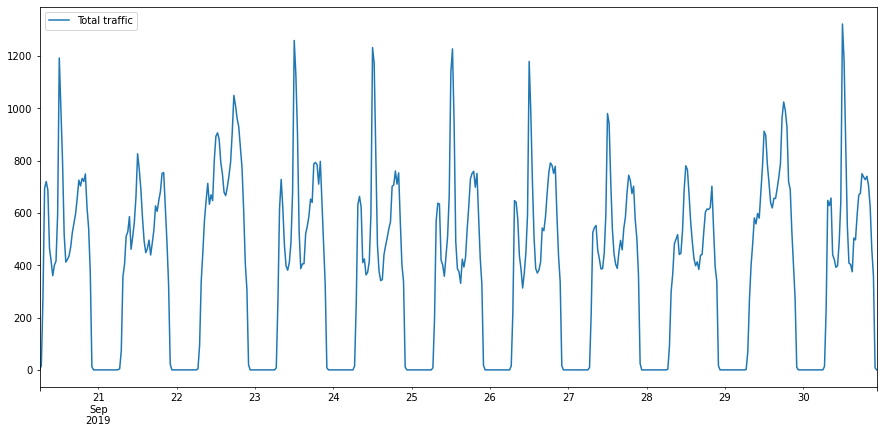

In [93]:
 #Sort the items by date is necessary, sometimes it isn't sorted ! ~30 items/month so it's fast
Traffic = dict(sorted(Traffic.items()))

df_traffic = pd.DataFrame(data = Traffic.values(), index=Traffic.keys(), columns = ["Total traffic"])
df_traffic.plot(figsize=(15,7))

In [94]:
ts_main = pd.Series(data = df_traffic[df_traffic.columns[0]], index=df_traffic.index)
print(ts_main)

2019-09-20 06:00:00      0
2019-09-20 06:30:00     17
2019-09-20 07:00:00    278
2019-09-20 07:30:00    694
2019-09-20 08:00:00    720
                      ... 
2019-09-30 20:30:00    623
2019-09-30 21:00:00    461
2019-09-30 21:30:00    359
2019-09-30 22:00:00      8
2019-09-30 22:30:00      0
Name: Total traffic, Length: 514, dtype: int64


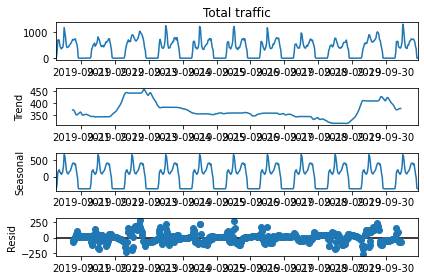

In [95]:
decomp = sm.tsa.seasonal_decompose(ts_main, period = season, model='additive')
decomp.plot()
plt.show()

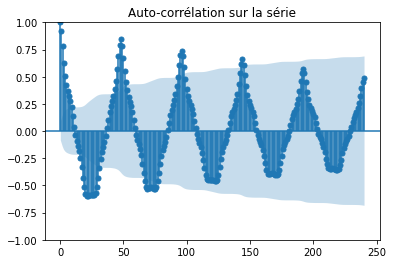

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


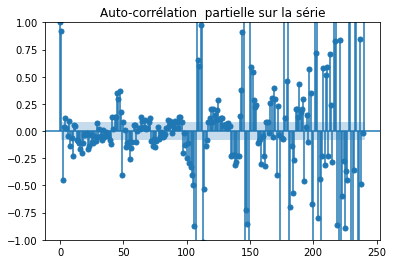

In [96]:
plot_acf(ts_main,lags = season*5, title = "Auto-corrélation sur la série")
plt.show()
plot_pacf(ts_main, lags = season*5, title = "Auto-corrélation  partielle sur la série")
plt.show()

In [97]:
def stationarity_test(ts):
    df_test = adfuller(ts, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of observations used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    return df_output
print(stationarity_test(ts_main))

Test Statistic                -8.923529e+00
p-value                        1.025786e-14
#Lags Used                     1.700000e+01
Number of observations used    4.960000e+02
Critical Value (1%)           -3.443603e+00
Critical Value (5%)           -2.867385e+00
Critical Value (10%)          -2.569883e+00
dtype: float64


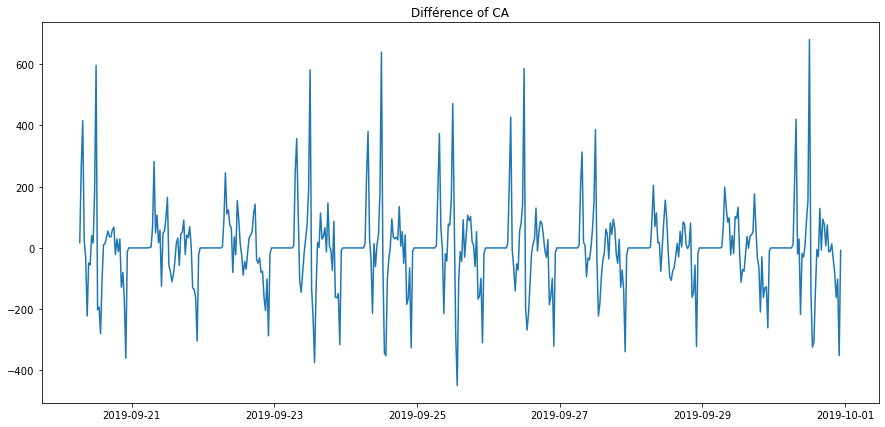

In [98]:
ts_d1 = pd.Series(data=ts_main - ts_main.shift(1), index=ts_main.index).dropna()       

plt.figure(figsize=(15,7))
plt.plot(ts_d1.index, ts_d1.values)
plt.title("Différence of CA")
plt.show()

In [99]:
print(stationarity_test(ts_d1))

Test Statistic                -6.444732e+00
p-value                        1.576142e-08
#Lags Used                     1.900000e+01
Number of observations used    4.930000e+02
Critical Value (1%)           -3.443684e+00
Critical Value (5%)           -2.867420e+00
Critical Value (10%)          -2.569902e+00
dtype: float64


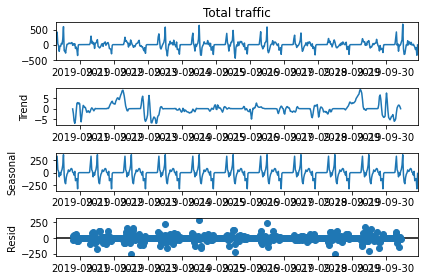

In [100]:
decomp_d1 = sm.tsa.seasonal_decompose(ts_d1,period = season, model='additive')
decomp_d1.plot()
plt.show()

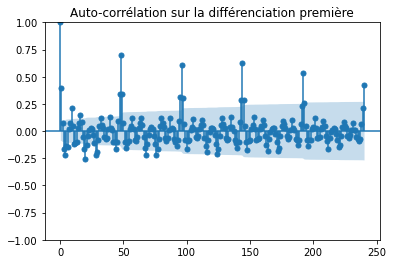

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


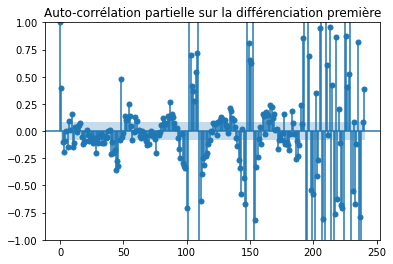

In [101]:
plot_acf(ts_d1,lags = season*5, title = "Auto-corrélation sur la différenciation première")
plt.show()
plot_pacf(ts_d1, lags = season*5, title = "Auto-corrélation partielle sur la différenciation première")
plt.show()

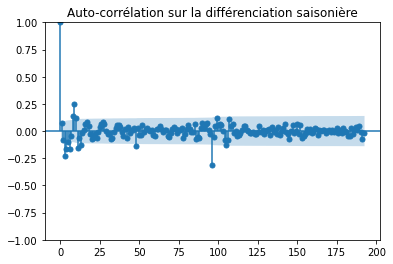

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


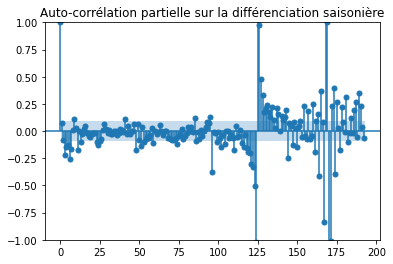

In [102]:
ts_d1d12 = pd.Series(data=ts_d1 - ts_d1.shift(season), index=ts_d1.index).dropna()  

plot_acf(ts_d1d12,lags = season*4, title = "Auto-corrélation sur la différenciation saisonière")
plt.show()
plot_pacf(ts_d1d12, lags = season*4, title = "Auto-corrélation partielle sur la différenciation saisonière")
plt.show()

In [ ]:
start = time()

train_main, val_main = train_test_split(ts_main,test_size = 1-alpha, shuffle = False)

auto_model = pm.auto_arima(train_main,d=0,D=1,seasonal=True, m=season, method = METHOD).fit(train_main)
print(auto_model)
# environ 6min
print("Time Taken to train model: ~" + str(int(time() - start)) + "secondes") 

In [ ]:
def cal_error(prediction, validation):
    # ERREURS QUADRATIQUES 
    N = len(prediction)
    
    erreurs_quad = [(prediction[i] - validation[i])**2 for i in range(N)]
    
    MSE = (sum(erreurs_quad)/N)
    RMSD = MSE**0.5
    NRMSD = RMSD/(max(validation-min(validation)))
    
    return NRMSD

In [ ]:
pred = auto_model.predict(n_periods = len(val_main))
pred = pd.Series(data=pred, index=[train_main.index[-1] +timedelta(minutes=hour_slice*(i+1)) for i in range(len(pred))])
print(pred)
err = cal_error(pred, val_main)

train_main.plot(label="Data",legend=True, figsize=(15,7))
pred.plot(label="Prédiction" ,legend=True)
plt.title("Données suivie de leurs prédictions"+ " E&G"*int(take_EG) +". Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/ALL_prediction1" + "_E&G"*int(take_EG) + ".jpg")
plt.show()

val_main.plot(label="Data",legend=True, figsize=(15,7))
pred.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions et données de validation superposées"+ " E&G"*int(take_EG) +". Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/ALL_prediction2" + "_E&G"*int(take_EG) + ".jpg")
plt.show()

In [ ]:
# def Recalc_with_feries(prediction):
#     jours_feries = []

#     d = min(prediction.index)
#     while d <= max(prediction.index):
#         if d.day == 1 and d.month == 1:
#             jours_feries.append(d)
#         elif d.day == 1 and d.month == 5:
#             jours_feries.append(d)
#         elif d.day == 21 and d.month == 7:
#             jours_feries.append(d)
#         elif d.day == 15 and d.month == 8:
#             jours_feries.append(d)
#         elif d.day == 1 and d.month == 11:
#             jours_feries.append(d)
#         elif d.day == 11 and d.month == 11:
#             jours_feries.append(d)
#         elif d.day == 25 and d.month == 12:
#             jours_feries.append(d)
            
#         paques = easter(d.year)
#         lundi_paques = paques + timedelta(days=1)
#         ascension    = paques + timedelta(days=40)
#         pentecote    = paques + timedelta(days=50)
        
#         if d==lundi_paques or d==ascension or d==pentecote:
#             jours_feries.append(d)
#         d+=timedelta(days=1)

#     for jf in jours_feries:
#         maximum = 0
#         for i in range(-season,season):
#             if jf + timedelta(days=i) in prediction.index:
#                 maximum = max(prediction[jf + timedelta(days=i)], maximum)
#         prediction[jf] = maximum
#     return prediction

In [ ]:
# if not take_EG:
#     err=cal_error(pred, val_main)

#     train_main.plot(label="Data",legend=True, figsize=(15,7))
#     pred.plot(label="Prédiction" ,legend=True)
#     plt.title("Données suivie de leurs prédictions. Error Score = " + str(int(err*100)) + " %")
#     if save_fig:
#         plt.savefig(save_folder+ "/ALL_prediction1_recalcule.jpg")
#     plt.show()

#     val_main.plot(label="Data",legend=True, figsize=(15,7))
#     pred.plot(label="Prédiction" ,legend=True)
#     plt.title("Prédictions et données de validation superposées. Error Score = " + str(int(err*100)) + " %")
#     if save_fig:
#         plt.savefig(save_folder+ "/ALL_prediction2_recalcule.jpg")
#     plt.show()


In [ ]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

## *Prediction du CA en fonction du temps par Magasin*

In [ ]:
sql_command = '''  
SELECT [MAGASIN.KEY]
      ,[Magasin.Libelle_magasin]
FROM ['''+DB+'''].[DWH].[Dim_Magasin]
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()


print(df_magasin)

In [ ]:
all_mag_key = set(df[MAGASIN + ".KEY"])

all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
all_mag_tra = {mag_key:{} for mag_key in all_mag_key}

bad, moyen, good = 0,0,0    
    
for mag_key in all_mag_key:
    print(mag_key, end = ': ')
    start = time()
    sql_command = "SELECT TOP (" + str(number_data) + ") "
    for cw in column_wanted:
        sql_command += '\n' + cw + ','
    sql_command = sql_command[:-1] + '''  
    FROM  ['''  + DB      + '''].[DWH].[Fact_''' + TABLE + ''']
    WHERE  [''' + TEMPS   + '''] >= ''' + str(date_to_key(start_date)) + '''
    AND ['''    + TEMPS   + '''] <= ''' + str(date_to_key(end_date))   + '''
    AND ['''    + TABLE   + '''.Nombre_articles] > 0 
    AND ['''    + MAGASIN + '''.KEY] = ''' + str(mag_key)
    
    conn = engine.connect()
    df_mag = pd.read_sql(sql_command, conn)
    conn.close()
    print("connexion done", end = '... ')

    traf = {}

    d        = datetime(start_date.year,start_date.month,start_date.day,6,0)
    while d < end_hour:
        traf[d] = 0
        d += timedelta(minutes=hour_slice)

    for i in range(number_data):
        traf[to_datetime(df[JOUR][i],df[HEURE][i])] += 1


    if do_log:
        for key in Traffic.keys():
            traf[key] = math.log(Traffic[key])/math.log(10)
  
    traf = dict(sorted(traf.items()))
    
    df_traffic_mag = pd.DataFrame(data  = traf.values(), 
                                      index = Traffic.keys(), 
                                      columns = ["Total traffic"])
    
    print("generate data done", end = '... ')
    
    if not df_traffic_mag.empty:
        if len(df_traffic_mag.values) > season * 10:
            ts_main_mag     = pd.Series(data = df_traffic_mag[df_traffic_mag.columns[0]], 
                                                                    index=df_traffic_mag.index)
            

            train_main_mag, val_main_mag = train_test_split(ts_main_mag,test_size = 1-alpha, shuffle = False)

            
            model = pm.auto_arima(train_main_mag,d=0,D=1,seasonal=True, m=season, 
                                        method = METHOD)
            print(model, end = '... ')
            
            pred_mag        = model.fit_predict(train_main_mag, n_periods = len(val_main_mag))
            pred_mag        = pd.Series(data=pred_mag,
                                        index=[train_main_mag.index[-1] +timedelta(days=i+1) for i in range(len(pred_mag))])

            if not take_EG:
                pred_mag        = Recalc_with_feries(pred_mag)
            
            err = cal_error(pred_mag, val_main_mag)
            
            train_main_mag[-season*8:].plot(label="Data",legend=True, figsize=(15,7))
            val_main_mag.plot(label="Data_VAL",legend=True, figsize=(15,7))
            pred_mag.plot(label = "Prédiction" ,legend=True)
            plt.title(mag_lib + " - Données & prédictions.  Error Score = " + str(int(err*100)) + " %")
            if save_fig:
                plt.savefig(save_folder+ "/MAG-" +mag_lib + "-prediction.jpg")
            plt.show()
            
            bad   += int(bool(err>BAD))
            moyen += int(bool(err<BAD and err >GOOD))
            good  += int(bool(err<GOOD))
            
        else:  
            df_traffic_mag.plot(figsize=(15,7), title = mag_lib)
            plt.show()
    
    print("Time taken for magasin " + str(mag_key) +"/"+str(max(all_mag_key))+ " " + (mag_lib if mag_lib != None else "?")
          + ": ~" + str(int(time() - start)) + " secondes") 
    
print("bad:",bad,"  moyen:", moyen,"  good:", good)

In [ ]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

In [51]:
results = {'nm'    :[12.929560,108.056167],
           'bfgs'  :[12.620287,556.962607],
           'powell':[12.670451,379.438504],
           'lbfgs' :[12.481309,419.550971],
           'cg'    :[15.907566,217.617969]}

all_mag_key = set(df[MAGASIN + ".KEY"])

all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
all_mag_rec = {mag_key:{} for mag_key in all_mag_key}

ind_temps = len(column_wanted)
ind_traffic = column_wanted.index("["+traffic+"]")
ind_mag = column_wanted.index("["+TABLE+".MAGASIN.KEY]")

for val in df.values:
    if not val[ind_temps] in all_mag_rec[val[ind_mag]].keys():
        all_mag_rec[val[ind_mag]][val[ind_temps]] = 0
    all_mag_rec[val[ind_mag]][val[ind_temps]] += val[ind_traffic]

    
all_df = {}    
for mag_key in all_mag_key:
    Traffic = all_mag_rec[mag_key]
    mag_lib = all_mag_lib[mag_key]

    Traffic = dict(sorted(Traffic.items()))
    
    if len(Traffic.values()) > season * 8:
        all_df[mag_key] =  (mag_lib, pd.DataFrame(data = Traffic.values(), 
                                          index=Traffic.keys(), 
                                          columns = ["Total traffic"]))

for m in results.keys():
    if len(results[m]) > 1:
        continue
    
    precision = 0
    temps = time()
    n = 20  #Max n ~= 36
    
    for (mag_key, (mag_lib, df_traffic_mag)) in list(all_df.items())[:n]:
        start = time()

        ts_main_mag     = pd.Series(data = df_traffic_mag[df_traffic_mag.columns[0]], 
                                                                index=df_traffic_mag.index)

        train_main_mag, val_main_mag = train_test_split(ts_main_mag,test_size = 1-alpha, shuffle = False)
        
        pred_mag        = pm.auto_arima(train_main_mag,d=0,D=1,seasonal=True, m=season, 
                                        method = m).fit_predict(train_main_mag, n_periods = len(val_main_mag))
        pred_mag        = pd.Series(data=pred_mag,
                                    index=[train_main_mag.index[-1] +timedelta(days=i+1) for i in range(len(pred_mag))])
        pred_mag        = Recalc_with_feries(pred_mag)
        
        err             = cal_error(pred_mag, val_main_mag)
        precision      += err

        print("Time taken for magasin " + str(mag_key) + " " + (mag_lib if mag_lib != None else "?")
              + ": ~" + str(int(time() - start)) + " secondes. " + 
              "\nMethod = " + m + " Error = " + str(err)) 

    
    results[m] = [precision*100/n, time()-temps]
    
print('-----------------------------------------------------------------')
print(pd.DataFrame(data = results.values(), 
                index=results.keys(), 
                columns = ["Erreur Moyenne (%)", "Temps Process"]))
print("Newton-Raphson & Newton Conjugate Gradient methods don't work for non-convex fonction.")
print("Powell doesn't seem to work for all dataset ?")
print("Basinhopping really takes a lot of time to run.")
print('-----------------------------------------------------------------')

-----------------------------------------------------------------
        Erreur Moyenne (%)  Temps Process
nm               12.929560     108.056167
bfgs             12.620287     556.962607
powell           12.670451     379.438504
lbfgs            12.481309     419.550971
cg               15.907566     217.617969
Newton-Raphson & Newton Conjugate Gradient methods don't work for non-convex fonction.
Powell doesn't seem to work for all dataset ?
Basinhopping really takes a lot of time to run.
-----------------------------------------------------------------
